In [ ]:
import torch
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
from graid.utilities.common import project_root_dir
import sys
import os
sys.path.insert(0, str(project_root_dir() / "install" / "DINO"))
sys.path.insert(0, str(project_root_dir() / "install" ))
from DINO.datasets import  transforms as T
import datasets.transforms as T

import requests
import os, sys
import torch, json
import numpy as np

from main import build_model_main
from util.slconfig import SLConfig
from util.visualizer import COCOVisualizer
from util import box_ops


In [10]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

In [3]:
model_config_path = "/work/ke/research/scenic-reasoning/install/DINO/config/DINO/DINO_4scale_swin.py" 
model_checkpoint_path = "/work/ke/research/scenic-reasoning/checkpoints/checkpoint0011_4scale_swin.pth"

In [ ]:
args = SLConfig.fromfile(model_config_path) 
args.device = 'cuda:7' 
torch.cuda.set_device(args.device)
model, criterion, postprocessors = build_model_main(args)
checkpoint = torch.load(model_checkpoint_path, map_location='cpu')
model.load_state_dict(checkpoint['model'])
_ = model.eval()

with open(str(project_root_dir() / "install" / "DINO/util/coco_id2name.json"), 'r') as f:
    id2name = json.load(f)
    id2name = {int(k):v for k,v in id2name.items()}

/work/ke/miniconda3/envs/scenic_reason/lib/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/work/ke/miniconda3/envs/scenic_reason/lib/python3.9/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


use_checkpoint!!!!!!!!!!!!!!!!!!!!!!!!


In [11]:
transform = T.Compose([
    T.RandomResize([800], max_size=1333),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
image, _ = transform(image, None)

TypeError: cannot unpack non-iterable builtin_function_or_method object

In [6]:
# Run the model with the image
# Adding None creates a batch dimension (converts from [C,H,W] to [1,C,H,W])
output = model.cuda()(image[None].cuda())
output = postprocessors['bbox'](output, torch.Tensor([[1.0, 1.0]]).cuda())[0]

/work/ke/miniconda3/envs/scenic_reason/lib/python3.9/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


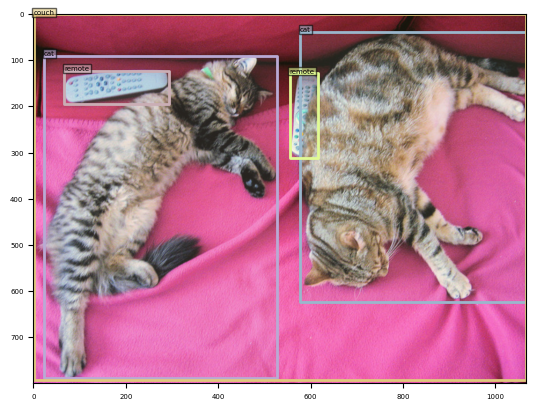

In [8]:
thershold = 0.3 # set a thershold

vslzr = COCOVisualizer()

scores = output['scores']
labels = output['labels']
boxes = box_ops.box_xyxy_to_cxcywh(output['boxes'])
select_mask = scores > thershold

box_label = [id2name[int(item)] for item in labels[select_mask]]
pred_dict = {
    'boxes': boxes[select_mask],
    'size': torch.Tensor([image.shape[1], image.shape[2]]),
    'box_label': box_label
}
vslzr.visualize(image, pred_dict, savedir=None, dpi=100)